**<h1><center>Stock Market Trend Prediction</center></h1>**

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will attempt to train/test our model with 2 different dataset ranges, one with past 4 years worth of stock data and the other with the past 20 years worth of stock data.

## Let us first take stock data starting from the year 2019
## (2019-04-26 till 2023-04-26)

In [ ]:
# importing the dataset
stock_data1 = pd.read_csv('file-path',index_col = 'Date')
stock_data1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-26,368.350006,375.140015,366.239990,374.850006,374.850006,5621900
2019-04-29,373.679993,374.579987,369.119995,371.829987,371.829987,3821700
2019-04-30,369.559998,374.500000,368.350006,370.540009,370.540009,3870100
2019-05-01,374.000000,385.989990,373.170013,378.809998,378.809998,9257300
2019-05-02,378.000000,383.500000,374.510010,379.059998,379.059998,5398200


In [ ]:
stock_data1.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-19,324.209991,325.750000,316.100006,323.119995,323.119995,22128300
2023-04-20,320.390015,331.429993,318.329987,325.350006,325.350006,9947800
2023-04-21,323.000000,328.290009,319.500000,327.980011,327.980011,6342600
2023-04-24,330.200012,334.660004,326.750000,329.019989,329.019989,5586600
2023-04-25,328.500000,328.660004,321.100006,322.549988,322.549988,5412100


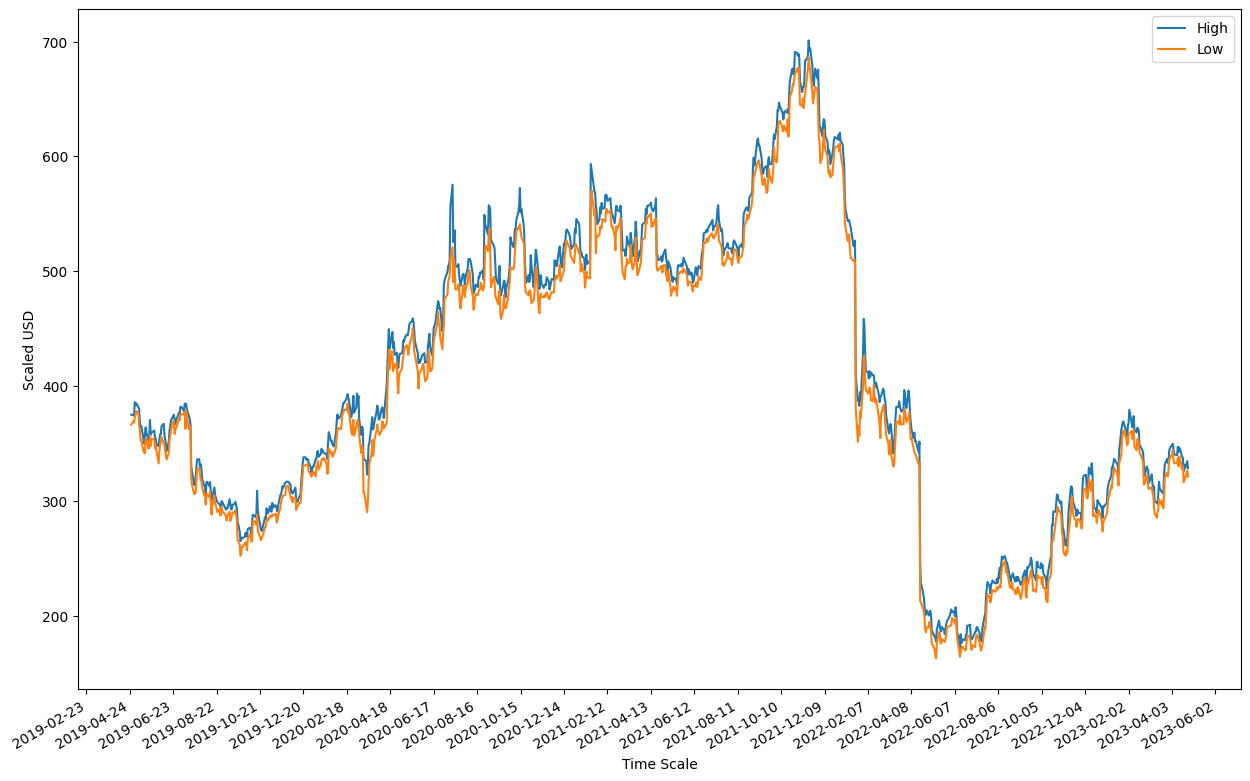

In [ ]:
# Plotting the high and low trend over the years (every two months)
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data1.index.values]

plt.plot(x_dates, stock_data1['High'], label='High')
plt.plot(x_dates, stock_data1['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Importing few key libraries we will be using throughout the project
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow. keras.layers import Dropout
from tensorflow.keras. layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
np.corrcoef(stock_data1['Close'],stock_data1['Volume'])

array([[ 1.        , -0.35147024],
       [-0.35147024,  1.        ]])

In [ ]:
# extracting the features we will be using for training our model and our target variable 'clode' which we will be predicting
target_y = stock_data1['Close']
X_feat= stock_data1.iloc[:,0:3]
print(X_feat)

                  Open        High         Low
Date                                          
2019-04-26  368.350006  375.140015  366.239990
2019-04-29  373.679993  374.579987  369.119995
2019-04-30  369.559998  374.500000  368.350006
2019-05-01  374.000000  385.989990  373.170013
2019-05-02  378.000000  383.500000  374.510010
...                ...         ...         ...
2023-04-19  324.209991  325.750000  316.100006
2023-04-20  320.390015  331.429993  318.329987
2023-04-21  323.000000  328.290009  319.500000
2023-04-24  330.200012  334.660004  326.750000
2023-04-25  328.500000  328.660004  321.100006

[1007 rows x 3 columns]


In [ ]:
# Scaling our training values so that it easier for our model to understand and efficiently learn from the input data
sc=StandardScaler()
X_ft =sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)

In [ ]:
# The function below takes the entire data and creates windows of size n_steps starting from the beginning.
# The target y will contain the target value corresponding to the n_steps’th index.
# So if n_steps is 10, the first element in X will have features from 10 data samples, and y will contain the target of the 10th data sample.
def lstm_split(data, n_steps):
  X, y= [], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [ ]:
# Splitting our data into train and test using the above function
X1, y1 = lstm_split(X_ft.values, n_steps=10)

train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(998, 10, 2) (799, 10, 2) (199, 10, 2) (199,)


In [ ]:
#Hyperparameter tuning our LSTM model using GridSearchCV and observing the losses/accuracies
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np

# Define the LSTM network architecture
def create_lstm_model(units=32, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', dropout=dropout_rate, return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

# Define the hyperparameters to search
param_grid = {'units': [32, 50, 64, 128], 'dropout_rate': [0, 0.2, 0.4, 0.6]}

# Create the LSTM model using KerasClassifier
model = KerasClassifier(build_fn=create_lstm_model, epochs=100, batch_size=4)

# Apply grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

<ipython-input-45-4176d85d8645>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm_model, epochs=100, batch_size=4)


Streaming output truncated to the last 5000 lines.
160/160 [==============================] - 2s 13ms/step - loss: 43169.9414 - accuracy: 0.0016
Epoch 14/100
160/160 [==============================] - 2s 14ms/step - loss: 41308.4062 - accuracy: 0.0016
Epoch 15/100
160/160 [==============================] - 2s 14ms/step - loss: 41505.5039 - accuracy: 0.0016
Epoch 16/100
160/160 [==============================] - 2s 15ms/step - loss: 41473.7070 - accuracy: 0.0016
Epoch 17/100
160/160 [==============================] - 2s 12ms/step - loss: 40869.9336 - accuracy: 0.0016
Epoch 18/100
160/160 [==============================] - 2s 13ms/step - loss: 41031.7773 - accuracy: 0.0016
Epoch 19/100
160/160 [==============================] - 2s 13ms/step - loss: 40133.0625 - accuracy: 0.0016
Epoch 20/100
160/160 [==============================] - 2s 12ms/step - loss: 40132.9414 - accuracy: 0.0016
Epoch 21/100
160/160 [==============================] - 2s 12ms/step - loss: 39609.7070 - accuracy: 0.0016

In [ ]:
# preparing the lstm model
lstm = Sequential ()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences=True))
lstm.add(LSTM(50,activation='relu'))
lstm.add(Dense (1))
lstm.compile (loss='mean_squared_error', optimizer='adam')
lstm.summary ()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_83 (LSTM)              (None, 10, 50)            10600     
                                                                 
 lstm_84 (LSTM)              (None, 50)                20200     
                                                                 
 dense_82 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training our lstm model
history=lstm.fit(X_train, y_train,epochs=100, batch_size=4,verbose=2, shuffle=False)

Epoch 1/100
200/200 - 7s - loss: 0.0841 - 7s/epoch - 33ms/step
Epoch 2/100
200/200 - 3s - loss: 0.0434 - 3s/epoch - 17ms/step
Epoch 3/100
200/200 - 3s - loss: 0.0407 - 3s/epoch - 15ms/step
Epoch 4/100
200/200 - 3s - loss: 0.0421 - 3s/epoch - 14ms/step
Epoch 5/100
200/200 - 3s - loss: 0.0471 - 3s/epoch - 13ms/step
Epoch 6/100
200/200 - 3s - loss: 0.0486 - 3s/epoch - 14ms/step
Epoch 7/100
200/200 - 3s - loss: 0.0395 - 3s/epoch - 14ms/step
Epoch 8/100
200/200 - 3s - loss: 0.0325 - 3s/epoch - 15ms/step
Epoch 9/100
200/200 - 3s - loss: 0.0291 - 3s/epoch - 15ms/step
Epoch 10/100
200/200 - 3s - loss: 0.0230 - 3s/epoch - 14ms/step
Epoch 11/100
200/200 - 3s - loss: 0.0202 - 3s/epoch - 13ms/step
Epoch 12/100
200/200 - 2s - loss: 0.0196 - 2s/epoch - 10ms/step
Epoch 13/100
200/200 - 2s - loss: 0.0219 - 2s/epoch - 9ms/step
Epoch 14/100
200/200 - 2s - loss: 0.0190 - 2s/epoch - 9ms/step
Epoch 15/100
200/200 - 2s - loss: 0.0159 - 2s/epoch - 12ms/step
Epoch 16/100
200/200 - 3s - loss: 0.0179 - 3s/epoch

In [ ]:
y_pred = lstm.predict(X_test)

7/7 [==============================] - 0s 5ms/step


In [ ]:
# checking rmse to get an idea on the accuracy of our model in predicting the stoc trends
import math
mse =mean_squared_error(y_test, y_pred, squared=False)
mape =mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ",math.sqrt(mse))
print("MAPE: ",mape)

RMSE:  0.16863577478949793
MAPE:  0.0310603619674742


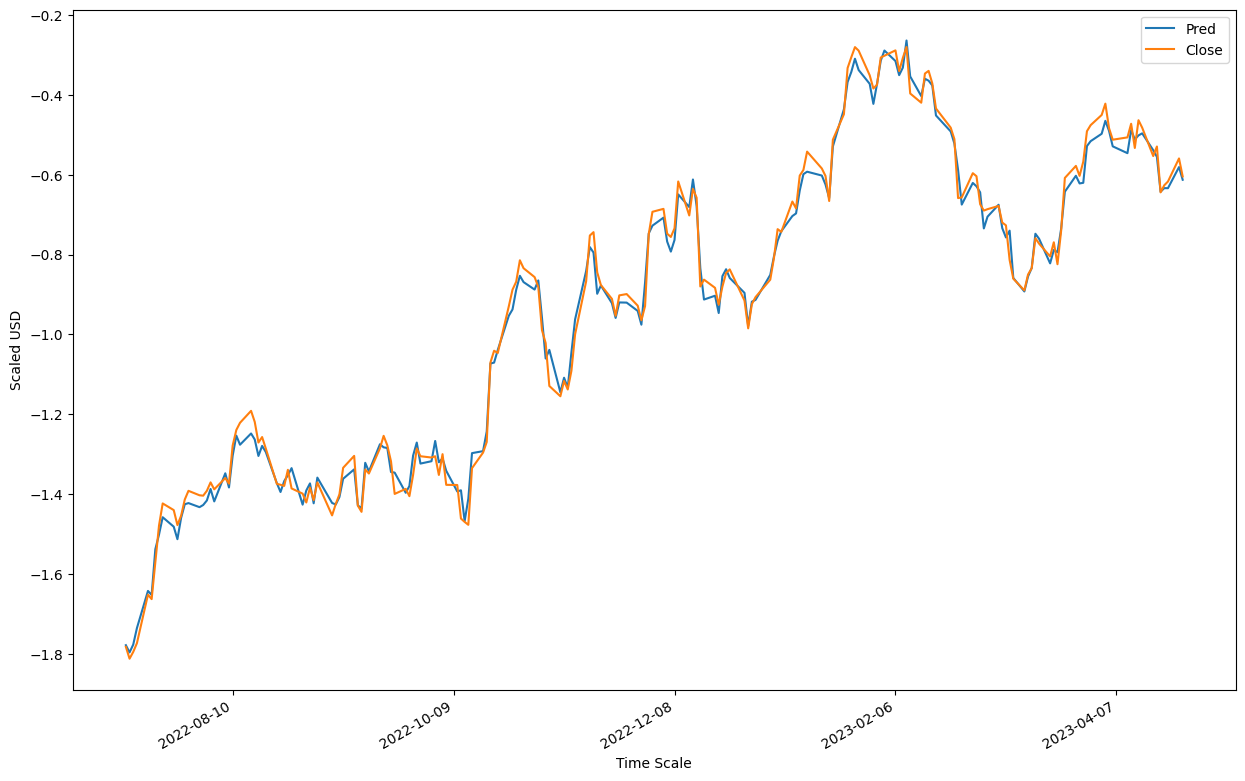

In [ ]:
# plotting our predicted values along with the actual values of the stock trends
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))


plt.plot(x_dates[808:],y_pred,label='Pred')
plt.plot(x_dates[808:],y_test,label="Close")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()


plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
meanopen = stock_data1["Open"].mean()
meanhigh = stock_data1["High"].mean()
meanlow = stock_data1["Low"].mean()
varopen = stock_data1["Open"].var()
varhigh = stock_data1["High"].var()
varlow = stock_data1["Low"].var()
print(meanopen)
print(meanhigh)
print(meanlow)
print(varopen)
print(varhigh)
print(varlow)

403.32512389275075
409.6229091122145
396.83787557000994
16034.298792588892
16236.181634008075
15718.529876091441


## Now, let's try to train and test our model with a stock dataset starting almost 20 years ago
## (2002-04-29 till 2023-04-29)

In [ ]:
stock_data = pd.read_csv('/content/drive/MyDrive/NFLX-2002.csv',index_col = 'Date')
stock_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-24,330.200012,334.660004,326.750000,329.019989,329.019989,5586600
2023-04-25,328.500000,328.660004,321.100006,322.549988,322.549988,5426600
2023-04-26,321.359985,325.899994,320.470001,321.149994,321.149994,4623200
2023-04-27,324.299988,327.450012,317.440002,325.850006,325.850006,5618800
2023-04-28,325.239990,330.809998,324.000000,329.929993,329.929993,4221900


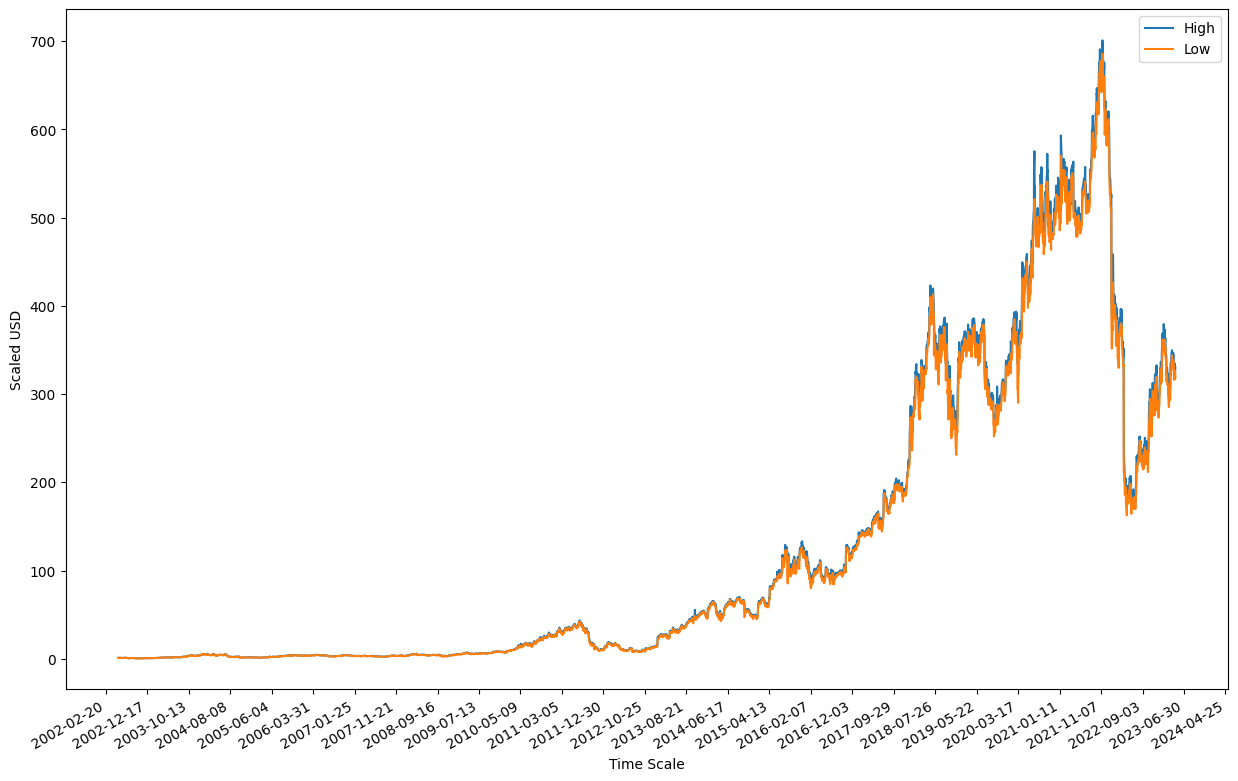

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))
x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
target_y = stock_data['Close']
X_feat= stock_data.iloc[:,0:3]

In [ ]:
sc=StandardScaler()
X_ft =sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)

In [ ]:
#Keeping in mind that the years 2020 and 2021 were outliers in terms of the volume traded,
#let's try excluding and including these two vital years in out training set and therefore, comparing accuracies and trends.

### Training and Testing with a 0.8 split:

In [ ]:
X1, y1 = lstm_split(X_ft.values, n_steps=10)

train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(5261, 10, 2) (4209, 10, 2) (1052, 10, 2) (1052,)


In [ ]:
lstm = Sequential ()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences=True))
lstm.add(LSTM(50,activation='relu'))
lstm.add(Dense (1))
lstm.compile (loss='mean_squared_error', optimizer='adam')
lstm.summary ()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 10, 50)            10600     
                                                                 
 lstm_86 (LSTM)              (None, 50)                20200     
                                                                 
 dense_83 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=lstm.fit(X_train, y_train,epochs=100, batch_size=4,verbose=2, shuffle=False)

Epoch 1/100
1053/1053 - 16s - loss: 0.0087 - 16s/epoch - 15ms/step
Epoch 2/100
1053/1053 - 11s - loss: 0.0050 - 11s/epoch - 11ms/step
Epoch 3/100
1053/1053 - 13s - loss: 0.0012 - 13s/epoch - 12ms/step
Epoch 4/100
1053/1053 - 11s - loss: 8.9006e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1053/1053 - 12s - loss: 8.0676e-04 - 12s/epoch - 11ms/step
Epoch 6/100
1053/1053 - 11s - loss: 6.9787e-04 - 11s/epoch - 10ms/step
Epoch 7/100
1053/1053 - 11s - loss: 6.7694e-04 - 11s/epoch - 11ms/step
Epoch 8/100
1053/1053 - 11s - loss: 8.0066e-04 - 11s/epoch - 11ms/step
Epoch 9/100
1053/1053 - 11s - loss: 8.6193e-04 - 11s/epoch - 11ms/step
Epoch 10/100
1053/1053 - 11s - loss: 0.0012 - 11s/epoch - 11ms/step
Epoch 11/100
1053/1053 - 10s - loss: 0.0014 - 10s/epoch - 10ms/step
Epoch 12/100
1053/1053 - 11s - loss: 0.0024 - 11s/epoch - 11ms/step
Epoch 13/100
1053/1053 - 11s - loss: 0.0015 - 11s/epoch - 11ms/step
Epoch 14/100
1053/1053 - 11s - loss: 7.2801e-04 - 11s/epoch - 11ms/step
Epoch 15/100
1053/1053 - 11s 

In [ ]:
y_pred = lstm.predict(X_test)

33/33 [==============================] - 0s 4ms/step


In [ ]:
mse =mean_squared_error(y_test, y_pred, squared=False)
mape =mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ",math.sqrt(mse))
print("MAPE: ",mape)

RMSE:  0.5058480544604118
MAPE:  0.08173830364724581


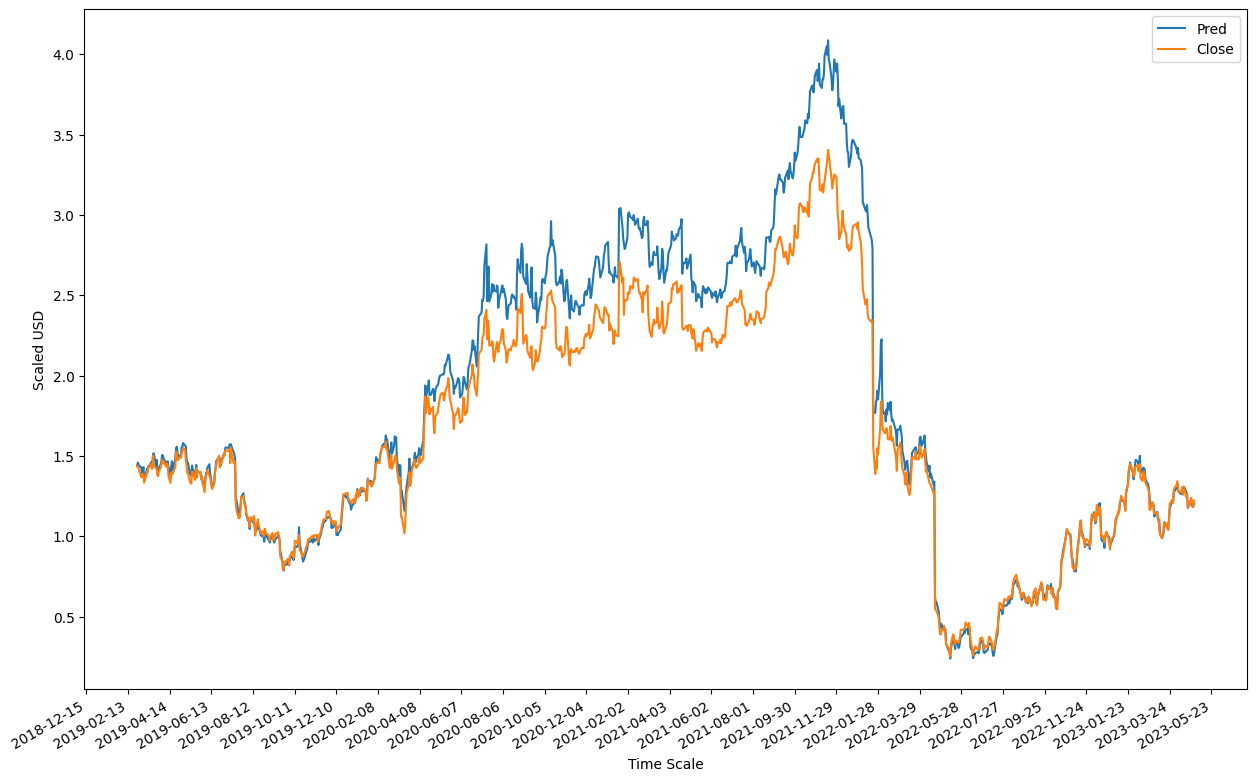

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))


plt.plot(x_dates[4218:],y_pred,label='Pred')
plt.plot(x_dates[4218:],y_test,label="Close")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Training and Testing with a 0.91 split:

In [ ]:
X1, y1 = lstm_split(X_ft.values, n_steps=10)

train_split=0.91
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)


(5261, 10, 2) (4788, 10, 2) (473, 10, 2) (473,)


In [ ]:
lstm = Sequential ()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences=True))
lstm.add(LSTM(50,activation='relu'))
lstm.add(Dense (1))
lstm.compile (loss='mean_squared_error', optimizer='adam')
lstm.summary ()


Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_87 (LSTM)              (None, 10, 50)            10600     
                                                                 
 lstm_88 (LSTM)              (None, 50)                20200     
                                                                 
 dense_84 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=lstm.fit(X_train, y_train,epochs=100, batch_size=4,verbose=2, shuffle=False)


Epoch 1/100
1197/1197 - 12s - loss: 0.0096 - 12s/epoch - 10ms/step
Epoch 2/100
1197/1197 - 9s - loss: 0.0152 - 9s/epoch - 8ms/step
Epoch 3/100
1197/1197 - 8s - loss: 0.0035 - 8s/epoch - 7ms/step
Epoch 4/100
1197/1197 - 9s - loss: 0.0039 - 9s/epoch - 8ms/step
Epoch 5/100
1197/1197 - 8s - loss: 0.0035 - 8s/epoch - 7ms/step
Epoch 6/100
1197/1197 - 9s - loss: 0.0037 - 9s/epoch - 8ms/step
Epoch 7/100
1197/1197 - 10s - loss: 0.0023 - 10s/epoch - 8ms/step
Epoch 8/100
1197/1197 - 8s - loss: 0.0018 - 8s/epoch - 7ms/step
Epoch 9/100
1197/1197 - 9s - loss: 0.0015 - 9s/epoch - 8ms/step
Epoch 10/100
1197/1197 - 9s - loss: 0.0012 - 9s/epoch - 8ms/step
Epoch 11/100
1197/1197 - 8s - loss: 0.0011 - 8s/epoch - 7ms/step
Epoch 12/100
1197/1197 - 9s - loss: 8.5929e-04 - 9s/epoch - 8ms/step
Epoch 13/100
1197/1197 - 9s - loss: 8.5679e-04 - 9s/epoch - 7ms/step
Epoch 14/100
1197/1197 - 9s - loss: 8.5012e-04 - 9s/epoch - 7ms/step
Epoch 15/100
1197/1197 - 9s - loss: 8.1725e-04 - 9s/epoch - 8ms/step
Epoch 16/100


In [ ]:
y_pred = lstm.predict(X_test)

15/15 [==============================] - 0s 4ms/step


In [ ]:
mse =mean_squared_error(y_test, y_pred, squared=False)
mape =mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ",math.sqrt(mse))
print("MAPE: ",mape)

RMSE:  0.2995179908006171
MAPE:  0.08037518105255637


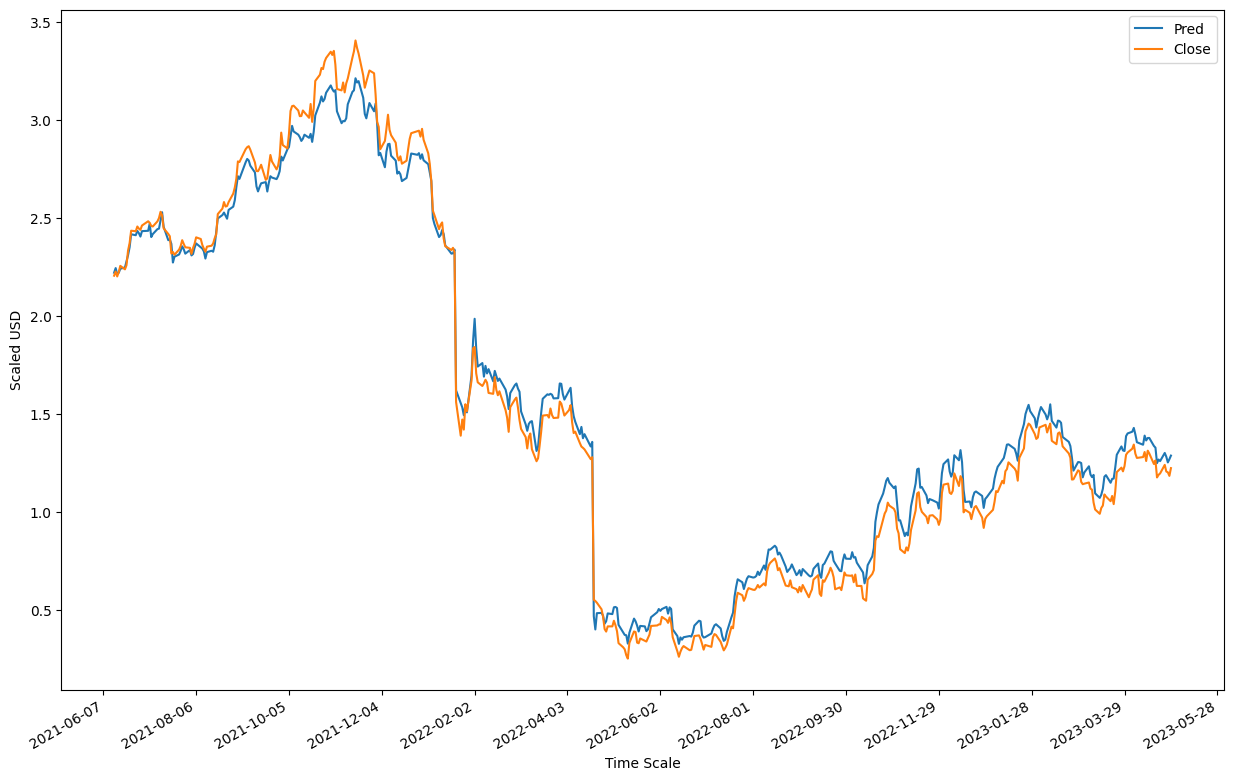

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))


plt.plot(x_dates[4797:],y_pred,label='Pred')
plt.plot(x_dates[4797:],y_test,label="Close")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()